In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.special import logsumexp
import pandas as pd
import pandasql as ps
from copy import deepcopy
from scipy.optimize import minimize 
from tqdm import tqdm_notebook

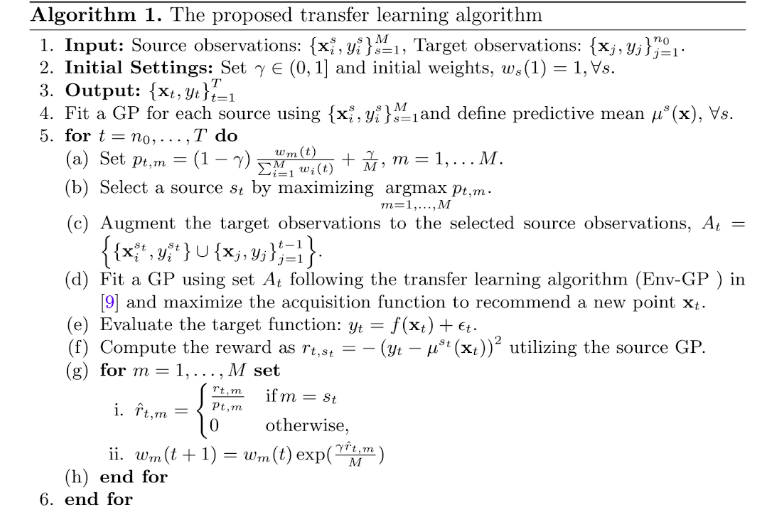

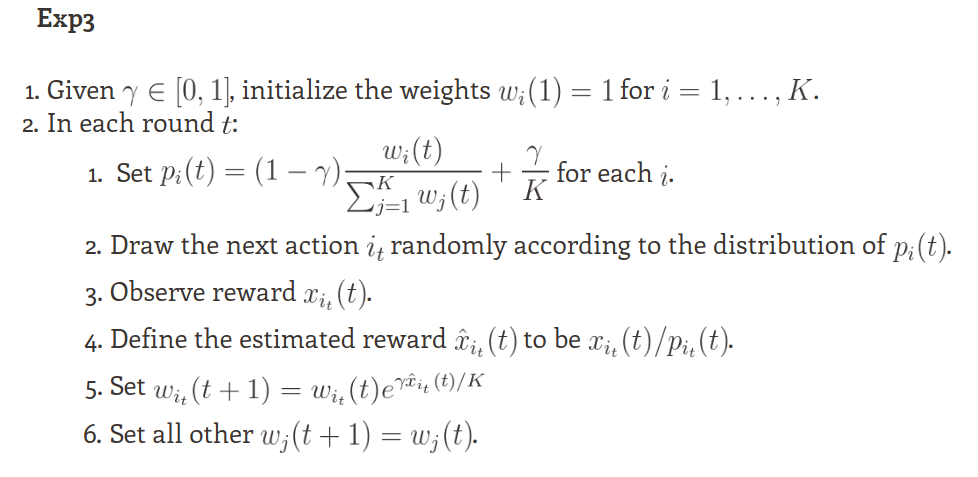

In [ ]:
def exp3(numActions, reward, gamma, reward_args=(), rewardMin = 0, rewardMax = 1):
    log_weights = np.array([0.0] * numActions)

    t = 0
    while True:
        probabilityDistribution = distr(log_weights, gamma)
        choice = draw(probabilityDistribution)
        theReward = reward(choice, *reward_args)
        scaledReward = (theReward - rewardMin) / (rewardMax - rewardMin) # rewards scaled to 0,1

        estimatedReward = scaledReward / probabilityDistribution[choice]
        log_weights[choice] += estimatedReward * gamma / numActions

        #yield choice, theReward, estimatedReward, log_weights, probabilityDistribution
        yield choice
        t = t + 1
        
def distr(log_weights, gamma=0.0):
    corrected_weights = log_weights - np.max(log_weights)
    theSum = logsumexp(corrected_weights)
    return (1.0 - gamma) * np.exp(corrected_weights - theSum) + (gamma / log_weights.shape[0])

'''
def draw(weights):
    choice = random.uniform(0, sum(weights))
    choiceIndex = 0

    for weight in weights:
        choice -= weight
        if choice <= 0:
            return choiceIndex

        choiceIndex += 1
'''

def draw(weights):
    return weights.argmax()

In [ ]:
def simple_test(arm):
    return -(1 - 1/(4-arm))**2

In [ ]:
class Env:
    def __init__(self,peak1, peak2, sigma1, sigma2):
        self.peak1 = peak1
        self.peak2 = peak2
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.f1 = multivariate_normal(peak1, sigma1)
        self.f2 = multivariate_normal(peak2, sigma2)
        
    def __call__(self,data):
        return (self.f1.pdf(data) + self.f2.pdf(data))/max(self.f1.pdf(self.peak1) + self.f2.pdf(self.peak1)\
                                            , self.f1.pdf(self.peak2) + self.f2.pdf(self.peak2))

In [ ]:
def get_gp_ucb_simple_sklearn( mu, sigma, forget):
    return mu + sigma * np.sqrt(forget)

def get_gp_ucb_advanced_sklearn( mu, sigma, delta, iteration, D, forget):
    rdelta = np.min(np.max(0,delta), 1)
    forget = 2*(2*np.log(iteration) + 2*np.log(np.pi)\
    - np.log(rdelta) + np.log(6) + np.log(D))
    return mu + sigma * np.sqrt(forget)

In [ ]:
def envelope_gp(sources, data, target, target_points_to_start, search_grid,\
                    number_of_iterations=100, sigma_msr=1e-10, forget=100, tao=1e-2, nu=1, gamma=0.9):
    
    target_data = target_points_to_start.copy()
    sigma_s = [sigma_msr] + [nu/(tao+1)]*len(sources)   # добавим пустой источник
    sources_ = [lambda data: None] + sources
    gp = GaussianProcessRegressor()
    gps = GaussianProcessRegressor()
    mu = 0
    log_weights = np.array([0.0] * len(sources_))
    history = []
    
    for t in range(number_of_iterations):
        
        probabilityDistribution = distr(log_weights, gamma)
        arm = draw(probabilityDistribution)
        history += [arm]
        
        alpha=np.vstack((sigma_s[arm]*np.ones((data.shape[0],1)),\
                                       sigma_msr*np.ones((target_data.shape[0],1)))).ravel()
        
        
        
        if arm != 0:
            gp.set_params(alpha=alpha)
            y = np.vstack((sources_[arm](data)[:,np.newaxis], target(target_data)[:,np.newaxis])).ravel()
            gp.fit(np.vstack((data, target_data)), y)
            gps.fit(data, sources_[arm](data))
        else:
            gp.set_params(alpha=sigma_msr)
            y = target(target_data)
            gp.fit(target_data, y)
            gps = deepcopy(gp)
        
        mu, sigma = gp.predict(search_grid, True)
        expected_improvement = get_gp_ucb_simple_sklearn(mu, sigma, forget)
        
        new_point = search_grid[np.argmax(expected_improvement)]
        
        theReward = -(target(new_point) - gps.predict(new_point[np.newaxis,:]))**2 / \
                        probabilityDistribution[arm]
            
        log_weights[arm] += theReward * gamma / len(sources_)
        
        target_data = np.vstack((target_data, np.array([new_point])))
        tao += 0.5
        nu += ((target(new_point) - gps.predict(new_point[np.newaxis,:]))**2)/2
        sigma_s[arm] = nu/(tao + 1)
        
    return mu, target_data, history


    

In [ ]:
def get_gp_ucb_simple_sklearn( X, gp, forget=100):
    mu, sigma = gp.predict(X, True)
    return mu + sigma * np.sqrt(forget) 

In [ ]:
def envelope_gp_acq_min(sources, data, target, target_points_to_start, bounds, search_grid, n_restarts=10,\
                    number_of_iterations=100, sigma_msr=1e-10, forget=100, tao=1e-2, nu=1, gamma=0.9):
    
    target_data = target_points_to_start.copy()
    sigma_s = [sigma_msr] + [nu/(tao+1)]*len(sources)   # добавим пустой источник
    sources_ = [lambda data: None] + sources
    gp = GaussianProcessRegressor()
    gps = GaussianProcessRegressor()
    log_weights = np.array([0.0] * len(sources_))
    history = []
    dim = data.shape[1]
    
    for _ in range(number_of_iterations):
        
        probabilityDistribution = distr(log_weights, gamma)
        arm = draw(probabilityDistribution)
        history += [arm]
        
        alpha=np.vstack((sigma_s[arm]*np.ones((data.shape[0],1)),\
                                       sigma_msr*np.ones((target_data.shape[0],1)))).ravel()
        
        if arm != 0:
            gp.set_params(alpha=alpha)
            y = np.vstack((sources_[arm](data)[:,np.newaxis], target(target_data)[:,np.newaxis])).ravel()
            gp.fit(np.vstack((data, target_data)), y)
            gps.fit(data, sources_[arm](data))
        else:
            gp.set_params(alpha=sigma_msr)
            y = target(target_data)
            gp.fit(target_data, y)
            gps = deepcopy(gp)
            
        expected_improvement = get_gp_ucb_simple_sklearn(search_grid, gp, forget)
        
        min_val= -np.max(expected_improvement)
        new_point = search_grid[np.argmax(expected_improvement)]
        for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
            min_obj = lambda x: -get_gp_ucb_simple_sklearn([x], gp, forget)
            res = minimize(min_obj, x0, method='L-BFGS-B', bounds=bounds)
            if res.fun < min_val:
                min_val = res.fun
                new_point = res.x
        
        #new_point = search_grid[np.argmax(expected_improvement)]
        
        theReward = -(target(new_point) - gps.predict(new_point[np.newaxis,:]))**2 / \
                        probabilityDistribution[arm]
            
        log_weights[arm] += theReward * gamma / len(sources_)
        
        target_data = np.vstack((target_data, np.array([new_point])))
        tao += 0.5
        nu += ((target(new_point) - gps.predict(new_point[np.newaxis,:]))**2)/2
        sigma_s[arm] = nu/(tao + 1)
        
    return  target_data, history


    

In [ ]:
def SMBO_transfer(sources, data, target, target_points_to_start, bounds, search_grid, n_restarts=10,\
                    number_of_iterations=100, sigma_msr=1e-10, forget=100, tao=1e-2, nu=1, gamma=0.9):
    
    target_data = target_points_to_start.copy() 
    t = target(target_points_to_start)
#    target_data = np.append(np.zeros((target_data.shape[0], 1)),\
#              target_data, axis=1) #добавим признак-индекс датасета, целевой == 0

    
    
    mu = t.mean()
    sigma = ((t - mu)**2).sum()**0.5
    
    enc = OneHotEncoder()

    source_marks = enc.fit_transform(np.arange(len(sources)+1).reshape(-1,1)).toarray()
    

    target_data = np.append(source_marks[0,:][np.newaxis,:] + np.zeros((target_data.shape[0], 1)),\
              target_data, axis=1)
    
    search_grid_ = np.append(source_marks[0,:][np.newaxis,:] + np.zeros((search_grid.shape[0], 1)),\
                             search_grid, axis=1)
    
    X = []
    y = []
    for i,s in enumerate(sources):
        f = s(data)
        mu_ = f.mean()
        sigma_ = ((f - mu_)**2).sum()**0.5
        y += [(f - mu_)/sigma_]
        data_ = data.copy()
#        data_ = np.append((i+1)*np.ones((data.shape[0], 1)), data, axis=1)
        data_ = np.append(source_marks[i+1,:][np.newaxis,:] + np.zeros((data.shape[0],1))\
                          , data, axis=1)
        X += [data_]
        
    y = np.hstack(y)
    X = np.vstack(X)

    gp = GaussianProcessRegressor()
    
    dim = data.shape[1]
    
    for _ in tqdm_notebook(range(number_of_iterations)):
        
        t_norm = (t - mu)/sigma
        #print(target_data.shape, target(target_data).shape)
        gp.fit(np.vstack((X, target_data)), np.hstack((y, t_norm)))
        
        expected_improvement = get_gp_ucb_simple_sklearn(search_grid_, gp, forget)
        
        min_val= -np.max(expected_improvement)
        new_point = search_grid_[np.argmax(expected_improvement)]
        for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
            min_obj = lambda x: -get_gp_ucb_simple_sklearn([x], gp, forget)
            x0 = np.append(source_marks[0,:], x0)
            bounds_ = np.append(source_marks[0,:][:, np.newaxis] + np.zeros((1,bounds.shape[1]))\
                                , bounds, axis=0)
            res = minimize(min_obj, x0, method='L-BFGS-B', bounds=bounds_)
            if res.fun < min_val:
                min_val = res.fun
                new_point = res.x
                
        t = np.append(t, target(new_point[source_marks.shape[1]:]))
        target_data = np.append(target_data, new_point[np.newaxis,:], axis=0)
        
        mu = t.mean()
        sigma = ((t - mu)**2).sum()**0.5
        
    
    return target_data, t, X, y

## Exp3-IX

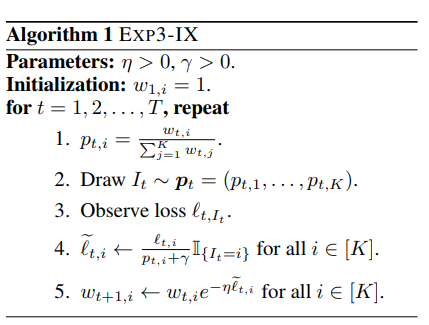

* выбор источника: применять разных бандитов(выбор руки из распределения|детерменированный: максимальная вероятность)
* Предлагаю для начала рассмотреть два возможных лосса: $(f(x_t) - \mu_{s_t}(x_t))^2$ и $(1 - f(x_t))^2$   
* Возможные опции работы со средами источниками: envelope-gp||общее функциональное пространство как в http://proceedings.mlr.press/v33/yogatama14.pdf
* оптимизация Acqusition: https://arxiv.org/pdf/1805.10196.pdf, DIRECT, градиентные методы
* как обрабатывать категориальные признаки: вместо gp нейросети, деревья|| автокодировщик|| https://arxiv.org/pdf/1805.03463.pdf
* попробовать применить к реальной задаче
* **ИДЕЯ!!!! допустим у нас есть различные датасеты на которых уже оценены какие-то наборы гиперпараметров, тогда можно дешево применить бандитов к ним и узнать как они связаны друг с другом!!!! таким образом можно понять как источники коррелируют друг с другом, тогда можно разбить датасеты на классы эквивалентности и оценить только представителей этих классов в качестве источников. Меньше рук -> быстрее exploration -> PROFIT!!**

* В ходе экспериментов выясноилась интересная связб между коэфициентом $\beta$ в UCB и связанностью источников. Если только один источник то можно смело брать коэффициент порядка 100, при нескольких источниках может процесс сходится быстрее, значит шаг необходимо уменьшать, тогда результаты становятся значительно лучше. При отсутствии хороших источников и высоком значении коэффициента происходит случайное блуждание по разным источникам, они становятся равномерными. Только под конец когда коэффициент постепенно уменьшается процесс выбирает отсутствие источника. Можно использовать данные наблюдения для анализа источников, их релевантности.

### Список статей и блогов идругих полезных ссылок:
* [1](http://web.eecs.umich.edu/~jabernet/eecs598course/fall2015/web/notes/lec22_120315.pdf)
* [2](https://books.google.ru/books?id=McpmDwAAQBAJ&pg=PA42&lpg=PA42&dq=Ramachandran+Selecting+optimal+source+for+transfer+learning+in+Bayesian+optimisation.&source=bl&ots=xHhpuHu1Nq&sig=ynRb1s6aEE9YaKHSvVH3OfybL34&hl=en&sa=X&ved=2ahUKEwj00v27kPXeAhWPKCwKHQLSBsQQ6AEwBHoECAQQAQ#v=onepage&q=iteration&f=true)
* [3](http://banditalgs.com/2016/10/01/adversarial-bandits/)
* [4](https://arxiv.org/pdf/1506.03271.pdf)
* [5](https://github.com/hibayesian/awesome-automl-papers#reinforcement-learning)
* [6](http://proceedings.mlr.press/v28/bardenet13.pdf)
* [7](http://proceedings.mlr.press/v33/yogatama14.pdf)
* [9](https://papers.nips.cc/paper/5086-multi-task-bayesian-optimization.pdf)
* [10](https://jeremykun.com/tag/exp3/)
* [11](https://arxiv.org/pdf/0912.3995.pdf)
* [12](https://www.sciencedirect.com/science/article/pii/S0957417418305311)
* [13](https://arxiv.org/pdf/1801.00857.pdf)
* [14](https://arxiv.org/pdf/1503.01673.pdf)
* [15](https://arxiv.org/pdf/1805.03463.pdf)
* [16](https://arxiv.org/pdf/0912.3995.pdf)
* [17](https://www.ml4aad.org/wp-content/uploads/2018/12/AutoML-Tutorial-NeurIPS2018-MetaLearning.pdf)
* [18](https://arxiv.org/pdf/1805.10196.pdf)
* [19](https://www.ml4aad.org/wp-content/uploads/2018/11/hpo.pdf)
* [20](https://www.ml4aad.org/wp-content/uploads/2018/12/metalearning.pdf)
* [21](https://arxiv.org/pdf/1502.05700.pdf)
* [22](http://proceedings.mlr.press/v80/lu18c/lu18c.pdf)
* [23](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/bcb15507f4b52991a0783013df4222240e942381.pdf)
* [24](https://www.cs.ubc.ca/~hutter/papers/10-TR-SMAC.pdf)
* [25](https://arxiv.org/pdf/1807.02811.pdf)
* [26](https://arxiv.org/pdf/1206.2944.pdf)
* [27](https://arxiv.org/pdf/1712.00424.pdf)
* [28](https://papers.nips.cc/paper/7111-bayesian-optimization-with-gradients.pdf)

In [ ]:
def distr_exp3_ix(log_weights, gamma=0.0):
    corrected_weights = log_weights - np.max(log_weights)
    theSum = logsumexp(corrected_weights)
    return np.exp(corrected_weights - theSum)

def myLoss1(mu,f):
    return (f-mu)**2
    
def myLoss2(mu,f):
    return (f-1)**2

In [ ]:
def exp3_ix_enveope_gp(sources, data, target, target_points_to_start, bounds, loss, search_grid,\
   n_restarts=10, number_of_iterations=100, sigma_msr=1e-10, forget=100, tao=1e-2, nu=1, gamma=None,\
                       lr_bandit_weights=None):
    
    target_data = target_points_to_start.copy()
    
    #envelope_gp
    sigma_s = [sigma_msr] + [nu/(tao+1)]*len(sources)   # добавим пустой источник
    sources_ = [lambda data: None] + sources # добавим пустой источник
    gp = GaussianProcessRegressor()
    gps = GaussianProcessRegressor()
    
    #MAB
    log_weights = np.array([0.0] * len(sources_))
    history = []
    dim = data.shape[1]
    K = len(sources_)
    
    #theorem 1 exp3_ix
    if gamma is None:
        gamma = np.sqrt(2*np.log(K)/(K*number_of_iterations))
        
    if lr_bandit_weights is None:
        lr_bandit_weights = 2*gamma
        
    #main
    for _ in range(number_of_iterations):
        
        probabilityDistribution = distr(log_weights, gamma)
        arm = draw(probabilityDistribution)
        history += [arm]
        
        alpha=np.vstack((sigma_s[arm]*np.ones((data.shape[0],1)),\
                                       sigma_msr*np.ones((target_data.shape[0],1)))).ravel()
        
        if arm != 0:
            gp.set_params(alpha=alpha)
            y = np.vstack((sources_[arm](data)[:,np.newaxis], target(target_data)[:,np.newaxis])).ravel()
            gp.fit(np.vstack((data, target_data)), y)
            gps.fit(data, sources_[arm](data))
        else:
            gp.set_params(alpha=sigma_msr)
            y = target(target_data)
            gp.fit(target_data, y)
            gps = deepcopy(gp)
        
        expected_improvement = get_gp_ucb_simple_sklearn(search_grid, gp, forget)
        
        min_val= -np.max(expected_improvement)
        new_point = search_grid[np.argmax(expected_improvement)]
        for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
            min_obj = lambda x: -get_gp_ucb_simple_sklearn([x], gp, forget)
            res = minimize(min_obj, x0, method='L-BFGS-B', bounds=bounds)
            if res.fun < min_val:
                min_val = res.fun
                new_point = res.x
        
        #new_point = search_grid[np.argmax(expected_improvement)]
        
        theReward = -loss(gps.predict(new_point[np.newaxis,:]),target(new_point))**2 / \
                        (probabilityDistribution[arm] + gamma)
            
        log_weights[arm] += theReward * lr_bandit_weights
        
        target_data = np.vstack((target_data, np.array([new_point])))
        tao += 0.5
        nu += ((target(new_point) - gps.predict(new_point[np.newaxis,:]))**2)/2
        sigma_s[arm] = nu/(tao + 1)
        
    return  target_data, history

### Различные среды

Источники

In [ ]:
params = [([i,i], [j,j], np.eye(2), np.eye(2)*0.25) for i,j in zip([-5,0.8,5,6],[-3,2.8,3,4])]

In [ ]:
sources = [Env(*args) for args in params]

Оригинал

In [ ]:
f = Env([0.7]*2, [2.7]*2, np.eye(2), np.eye(2)*0.25)

### Сгенерируем точки

In [ ]:
theta = np.linspace(-4., 5., 10)
X, Y = np.meshgrid(theta,theta)
data = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

In [ ]:

fig = plt.figure()
ax = Axes3D(fig)
for i, (s, name) in enumerate(zip(sources, ['r', 'b', 'g', 'c' ])):
    #ax = fig.add_subplot(1, len(sources), i+1, projection='3d')
    Z = s(data)
    ax.plot_wireframe(X, Y,
        Z.reshape(X.shape), alpha=0.5, color = name )


In [ ]:
theta = np.linspace(-4., 5., 30)
X, Y = np.meshgrid(theta,theta)
search_grid = np.append(X.reshape(-1,1), Y.reshape(-1,1), axis = -1)

pd_data = pd.DataFrame(data, columns=['x', 'y'])
pd_grid = pd.DataFrame(search_grid, columns=['x', 'y'])

query = '''
select * from pd_grid
except
select * from pd_data
'''

pd_grid = ps.sqldf(query)

search_grid = np.array(pd_grid)

In [ ]:
starting_points = np.random.uniform([-4,-4], [5,5], size=(2,2))

### MAB exp3

In [ ]:
target_data, history = envelope_gp_acq_min(sources, data, f, starting_points,\
                   np.array([[-4,5], [-4,5]]), search_grid, number_of_iterations=30, n_restarts=5)

In [ ]:
f(target_data)

In [ ]:
np.unique(history, return_counts=True)

In [ ]:
np.max(f(target_data))

In [ ]:
target_data[np.argmax(f(target_data))]

### Simple BO

In [ ]:
target_data, history = envelope_gp_acq_min([], data, f, starting_points,\
                       np.array([[-4,5], [-4,5]]), search_grid, n_restarts=5, number_of_iterations=30)

In [ ]:
np.argmax(f(target_data))

In [ ]:
np.max(f(target_data))

In [ ]:
np.unique(history, return_counts=True)

In [ ]:
target_data[np.argmax(f(target_data))]

### SMBO transfer from http://proceedings.mlr.press/v33/yogatama14.pdf

In [ ]:
%time target_data, t, X, y = SMBO_transfer(sources, data, f, starting_points,\
               np.array([[-4,5], [-4,5]]), search_grid, number_of_iterations=30, n_restarts=5)

In [ ]:
target_data.shape

In [ ]:
X

In [ ]:
np.max(t)

In [ ]:
np.argmax(t)

In [ ]:
t

### MAB exp3-IX

In [ ]:
res = exp3_ix_enveope_gp(sources, data, f, starting_points,  np.array([[-4,5], [-4,5]]), myLoss1, search_grid,\
        n_restarts=5, number_of_iterations=30, sigma_msr=1e-10, forget=100, tao=1e-2, nu=1, gamma=None,\
                       lr_bandit_weights=None)

In [ ]:
np.max(f(res[0]))

In [ ]:
_, counts = np.unique(res[1], return_counts=True)

In [ ]:
counts

In [ ]:
res2 = exp3_ix_enveope_gp(sources, data, f, starting_points,  np.array([[-4,5], [-4,5]]), myLoss2, search_grid\
   n_restarts=20, number_of_iterations=30, sigma_msr=1e-10, forget=100, tao=1e-2, nu=1, gamma=None,\
                       lr_bandit_weights=None)

In [ ]:
np.max(f(res2[0]))

In [ ]:
_, counts = np.unique(res2[1], return_counts=True)

In [ ]:
counts